#**Variational AutoEncoder (VAE) on the MNIST handwritten digit dataset**# 

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

**Hyperparameters**

1.   lr : Learning rate set to 0.001 for the RMSProp optimizer
2.   epochs : Number of training epochs
3.   img_dim : Dimension of flattened $28*28$ MNIST image
4.   nn_dim : Dimension of encoder/decoder Dense layer
5.   lv_dim : Dimension of latent variable representation of the VAE


In [0]:
lr = 1e-3
epochs = 20000
img_dim = 784 #28x28 images
nn_dim = 512 #encoder/decoder dense layer
lv_dim = 2 #lower dimensional representation

Xavier initialization, given by $1/{\sqrt{\frac{n}{2}}}$ where $n$ represents input dimension

In [0]:
def Xavier(in_shape):
  return tf.random_normal(shape = in_shape, stddev = 1./tf.sqrt(in_shape[0]/2.))

Initialize the weight and bias matrices using Xavier initialization

In [4]:
Weight = {'W_inp_enc' : tf.Variable(Xavier([img_dim, nn_dim])),
          'W_enc_mean' : tf.Variable(Xavier([nn_dim, lv_dim])),
          'W_enc_std' : tf.Variable(Xavier([nn_dim, lv_dim])),
          'W_lv_dec' : tf.Variable(Xavier([lv_dim, nn_dim])),
          'W_dec_out' : tf.Variable(Xavier([nn_dim, img_dim]))    
}

Bias = {'B_enc' : tf.Variable(Xavier([nn_dim])),
        'B_mean' : tf.Variable(Xavier([lv_dim])),
        'B_std' : tf.Variable(Xavier([lv_dim])),
        'B_dec' : tf.Variable(Xavier([nn_dim])),
        'B_out' : tf.Variable(Xavier([img_dim]))
}

Instructions for updating:
Colocations handled automatically by placer.


**Network definition**

1.   Input layer (shape = $[batch\_size, 784]$)
2.   Encoder layer (input shape = $[batch\_size, 784]$, output shape = $[batch\_size, 512]$, activation = $tanh()$)
3.   Mean layer (input shape = $[batch\_size, 512]$, output shape = $[batch\_size, 2]$)
4.   Standard Deviation layer (input shape = $[batch\_size, 512]$, output shape = $[batch\_size, 2]$)
5.   Latent layer (input shape = $[batch\_size, 2,2]$, output shape = $[batch\_size, 2]$)
6.   Decoder layer (input shape = $[batch\_size, 2]$, output shape = $[batch\_size, 512]$, activation = $tanh()$)
7.   Output layer (input shape = $[batch\_size, 512]$, output shape =  $[batch\_size, 784]$, activation = $sigmoid()$)



In [0]:
inp = tf.placeholder(tf.float32, shape = [None, img_dim])
encoder = tf.add(tf.matmul(inp, Weight['W_inp_enc']), Bias['B_enc'])
encoder = tf.nn.tanh(encoder)

mean = tf.add(tf.matmul(encoder, Weight['W_enc_mean']), Bias['B_mean'])
stddev = tf.add(tf.matmul(encoder, Weight['W_enc_std']), Bias['B_std'])

In the standard setup, derivative of the loss function with respect to the parameters of encoder network is not feasible as expectation term in the loss draws samples from the distribution defined by these parameters. Hence a reparametrization trick is used wherein a new variable $\epsilon$ drawn from $N(0,1)$ is introduced. 

The encoder function is then given by 
$g_\phi(\epsilon,X) = \mu_\phi(X) + \epsilon*\Sigma^{1/2}_\phi(X)$

In [0]:
epsilon = tf.random_normal(tf.shape(stddev), dtype = tf.float32, mean = 0.0, stddev = 1.0)
latent_layer = tf.add(mean, tf.exp(0.5*stddev)*epsilon)

In [0]:
decoder = tf.add(tf.matmul(latent_layer, Weight['W_lv_dec']), Bias['B_dec'])
decoder = tf.nn.tanh(decoder)

In [0]:
out = tf.add(tf.matmul(decoder, Weight['W_dec_out']), Bias['B_out'])
out = tf.nn.sigmoid(out)

The loss function includes two parts

1. Data fidelity loss
> The data fidelity or reconstruction loss is given by $L_{df}(X,\hat{X}) = X*\log(\hat{X}) + (1 - X)*\log(1 - \hat{X})$ and is used to measure the quality of reconstruction of the image by comparing the generated output $\hat{X}$ to the original image $X$
2. KL divergence 
> The KL divergence loss aims to capture $D_{KL}(q_\phi(z|x) || p_\theta(z))$ or the difference in distributions of the functions defined by the encoder and the decoder modules. Proper selection of $p_\theta$ can effectively mean that KL divergence loss acts as an inherent regularizer



The loss function is hence given as $L(\theta, \phi) = \alpha*L_{df}(X,\hat{X}) + \beta*D_{KL}(q_\phi(z|x) || p_\theta(z))$ where $\alpha$ and $\beta$ are network hyperparameters

In [0]:
def loss_fn(original, reconstructed):
  eps = 1e-10
  df_loss = original*tf.log(eps + reconstructed) + ((1 - original)*tf.log(eps + 1 - reconstructed))
  df_loss = -tf.reduce_sum(df_loss, 1)
  
  kl_div = 1 + stddev - tf.square(mean) - tf.exp(stddev)
  kl_div = -0.5*tf.reduce_sum(kl_div, 1)
  
  alpha = 1
  beta = 1
  
  return tf.reduce_mean(alpha*df_loss + beta*kl_div)

In [10]:
loss = loss_fn(inp, out)
optimizer = tf.train.RMSPropOptimizer(lr).minimize(loss)

Instructions for updating:
Use tf.cast instead.


Load, verify and visualize the MNIST dataset

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
x_train.shape

(60000, 28, 28)

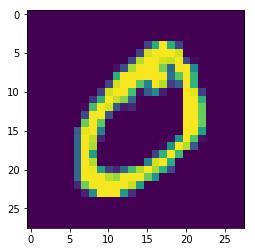

In [13]:
plt.imshow(x_train[1])

Train the network with the previously set hyperparameters without using mini-batches

In [14]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

x_train = np.reshape(x_train, [-1, img_dim])

for i in range(epochs):
  _, loss_val = sess.run([optimizer, loss], feed_dict = {inp: x_train})
  if i%100 == 0:
    print("Loss after {0} epochs is {1} ".format(i, loss_val))

Loss after 0 epochs is 626.786376953125 
Loss after 100 epochs is 200.85523986816406 
Loss after 200 epochs is 193.97686767578125 
Loss after 300 epochs is 190.07398986816406 
Loss after 400 epochs is 183.54920959472656 
Loss after 500 epochs is 176.34771728515625 
Loss after 600 epochs is 173.1588897705078 
Loss after 700 epochs is 170.92776489257812 
Loss after 800 epochs is 169.33399963378906 
Loss after 900 epochs is 168.83477783203125 
Loss after 1000 epochs is 168.3453369140625 
Loss after 1100 epochs is 167.82412719726562 
Loss after 1200 epochs is 164.95916748046875 
Loss after 1300 epochs is 166.77822875976562 
Loss after 1400 epochs is 165.3499298095703 
Loss after 1500 epochs is 163.18763732910156 
Loss after 1600 epochs is 162.7821807861328 
Loss after 1700 epochs is 163.1947021484375 
Loss after 1800 epochs is 169.1067352294922 
Loss after 1900 epochs is 161.97494506835938 
Loss after 2000 epochs is 160.98023986816406 
Loss after 2100 epochs is 158.604736328125 
Loss after

To test the network, we require only the decoder module and we feed noise in the place of the latent encodings to the decoder Dense layer

In [0]:
noise = tf.placeholder(tf.float32, shape = [None, lv_dim])
decoder = tf.add(tf.matmul(noise, Weight['W_lv_dec']), Bias['B_dec'])
decoder = tf.nn.tanh(decoder)
out = tf.add(tf.matmul(decoder, Weight['W_dec_out']), Bias['B_out'])
out = tf.nn.sigmoid(out)

Saving the model to Drive

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
saver = tf.train.Saver()
save_path = saver.save(sess, "/content/drive/My Drive/model.ckpt")

Visualizing the decoder output by constructing a $20*20$ grid sampled for varying latent variable encodings

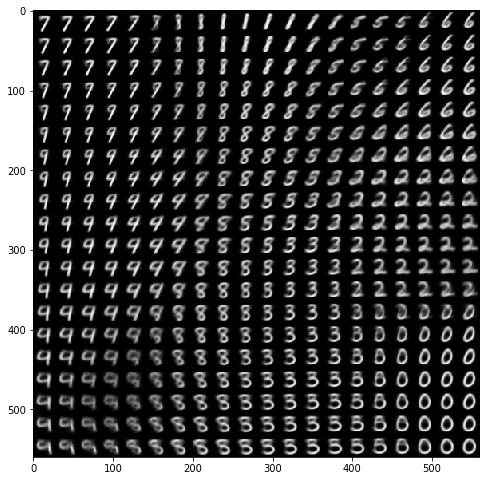

In [30]:
n = 20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)

test_img = np.empty((28*n,28*n))

for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    gen_layer = np.array([[zi,pi]] * 32)
    gen_img = sess.run(out, feed_dict = {noise : gen_layer})
    test_img[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = gen_img[0].reshape(28,28)
    
plt.figure(figsize = (8,10))
X,Y = np.meshgrid(x_limit, y_limit)
plt.imshow(test_img, origin = 'upper', cmap = 'gray')
plt.grid(False)
plt.show()